In [17]:
# https://www.openml.org/apis

import openml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [18]:
# Importar o dataset

suite = openml.study.get_suite(99)

task_id = 37
task = openml.tasks.get_task(task_id)    

dataset = openml.datasets.get_dataset(task.dataset_id)

X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

# Visualizar o dataset

df = pd.DataFrame(X, columns=attribute_names)
df['target'] = y

df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,target
0,6.0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.299999,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.099998,2.288,33.0,1


<AxesSubplot:xlabel='target', ylabel='count'>

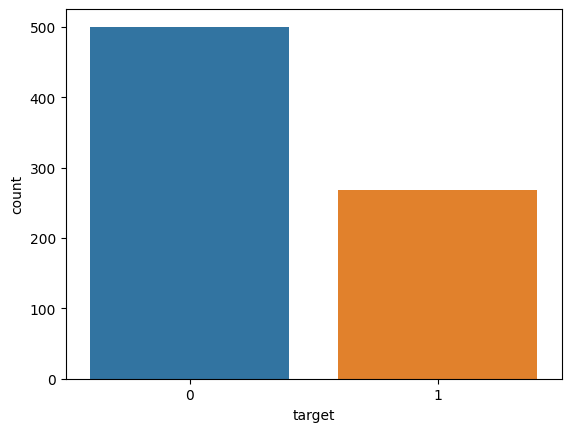

In [19]:
# Visualizar a distribuição das classes

sns.countplot(x='target', data=df)

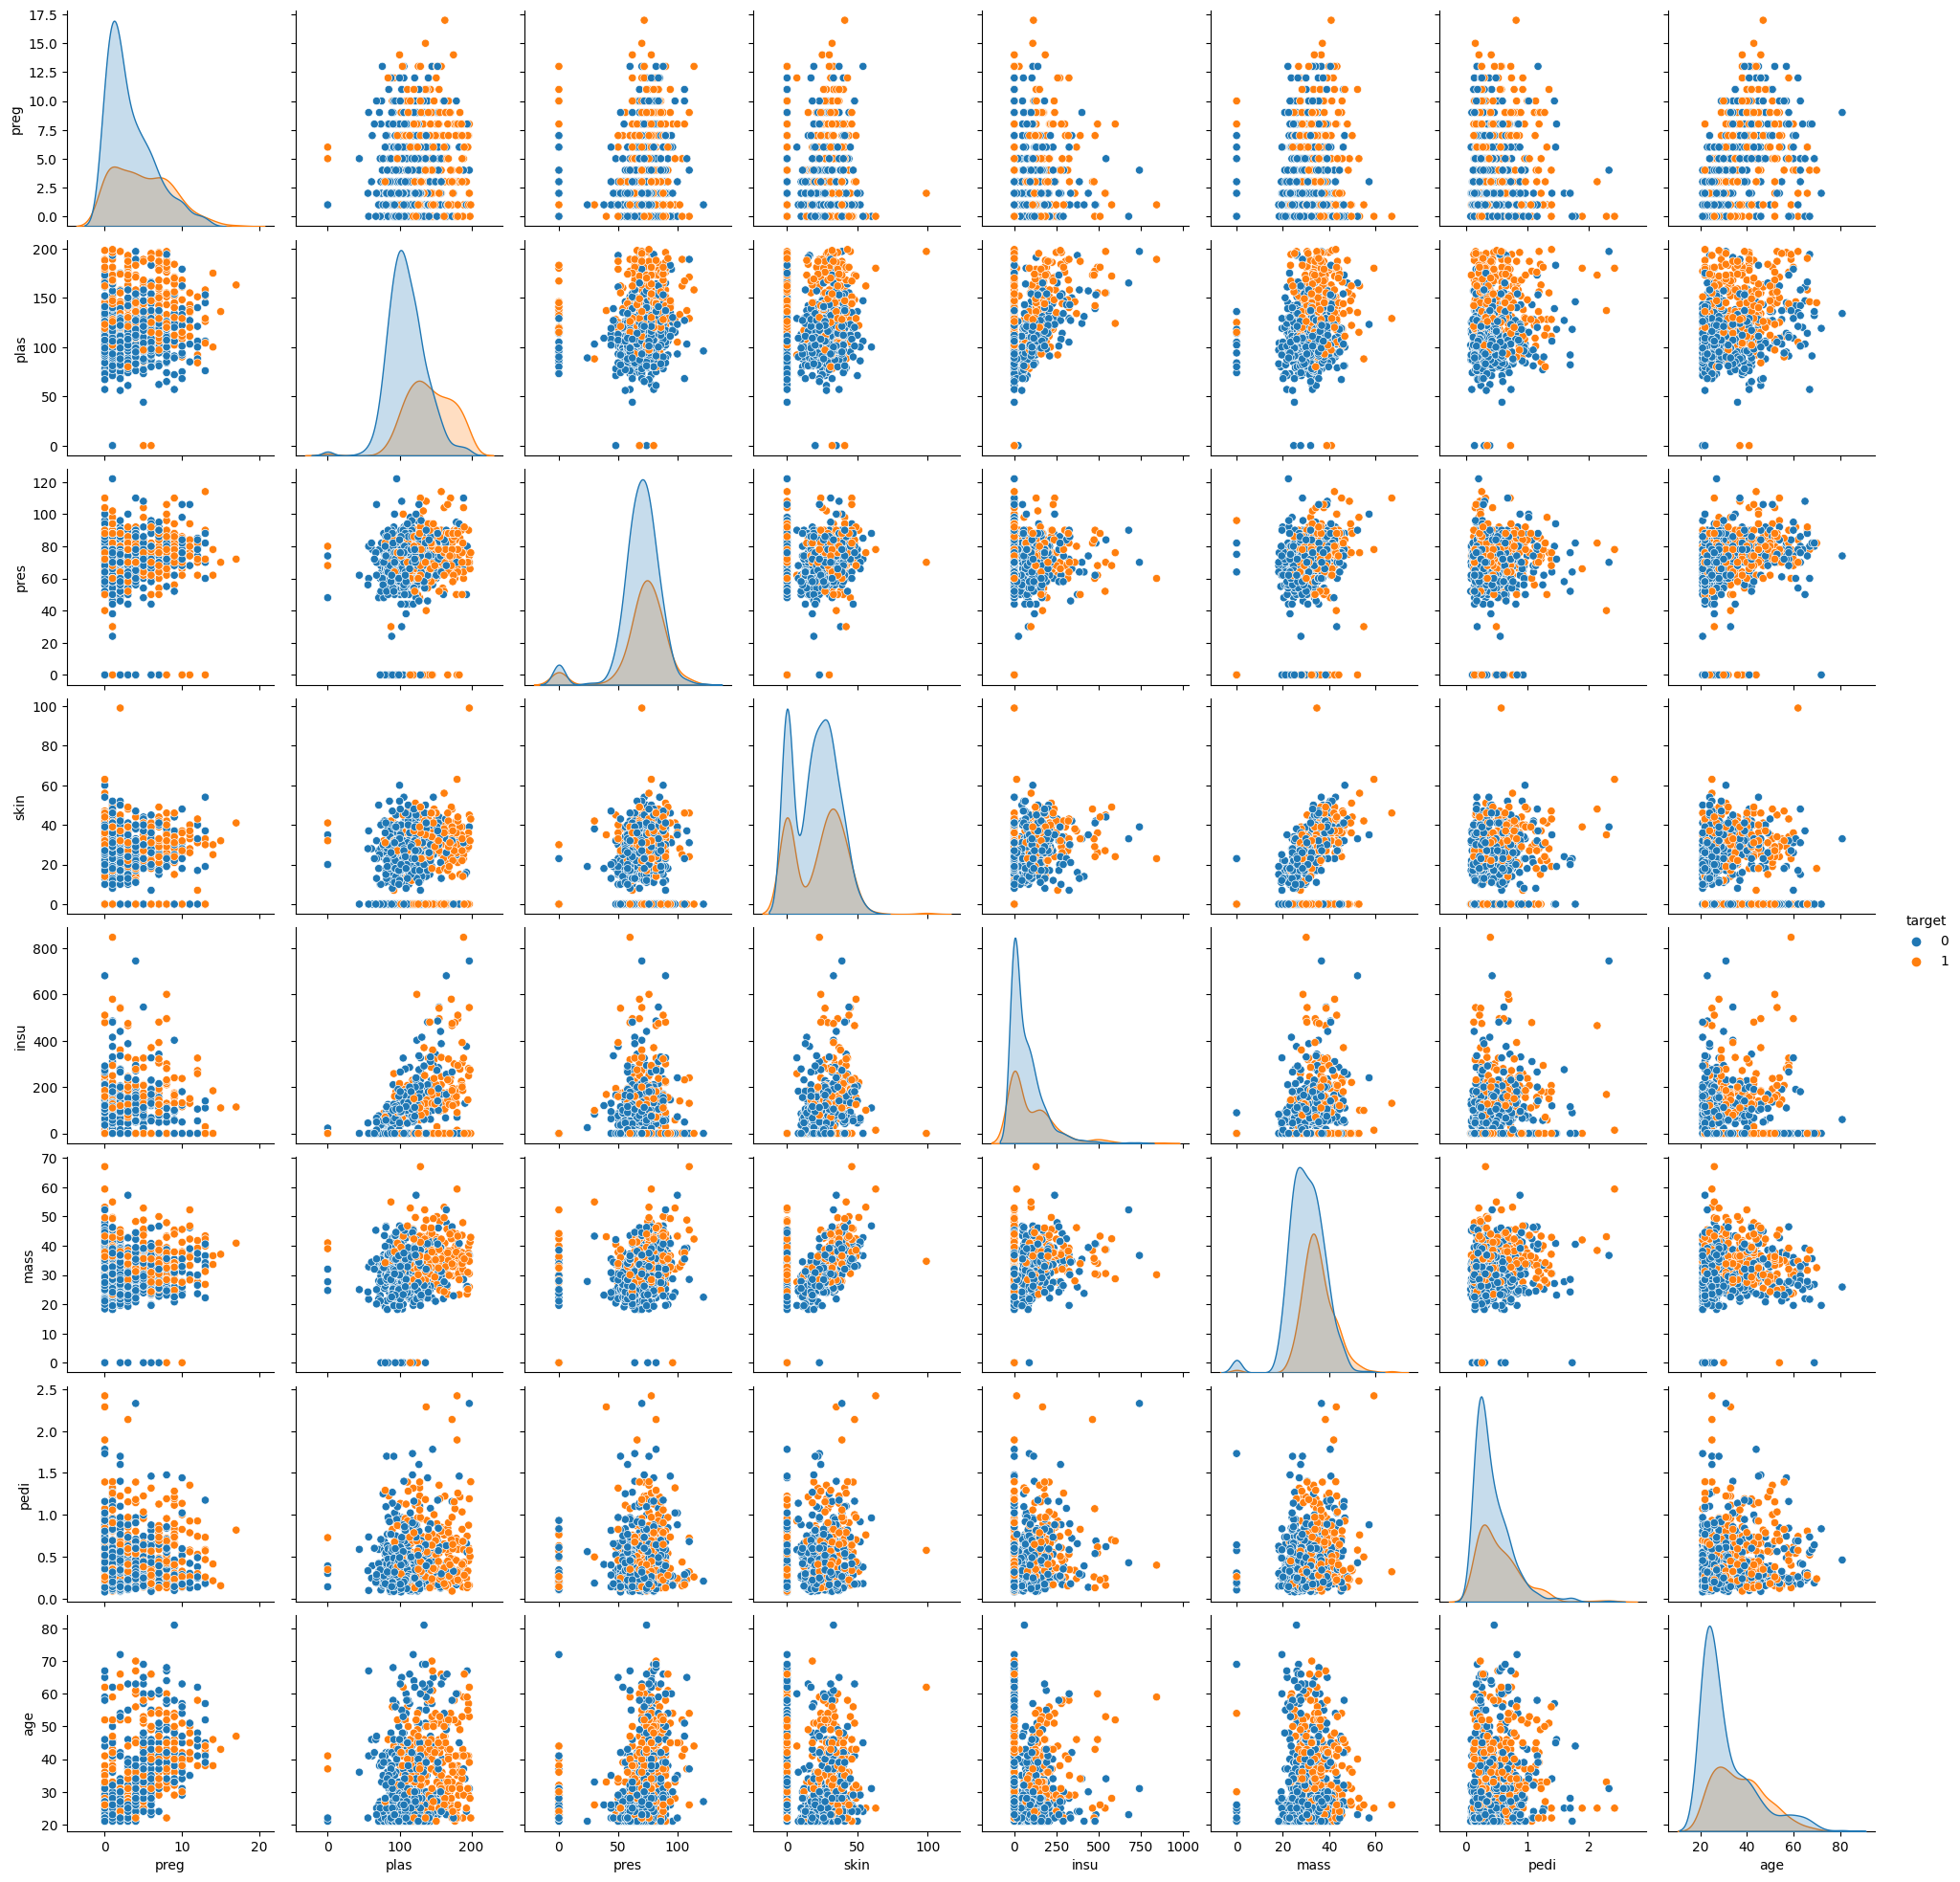

In [21]:
# Pairplot

sns.pairplot(df, hue='target')
plt.show()

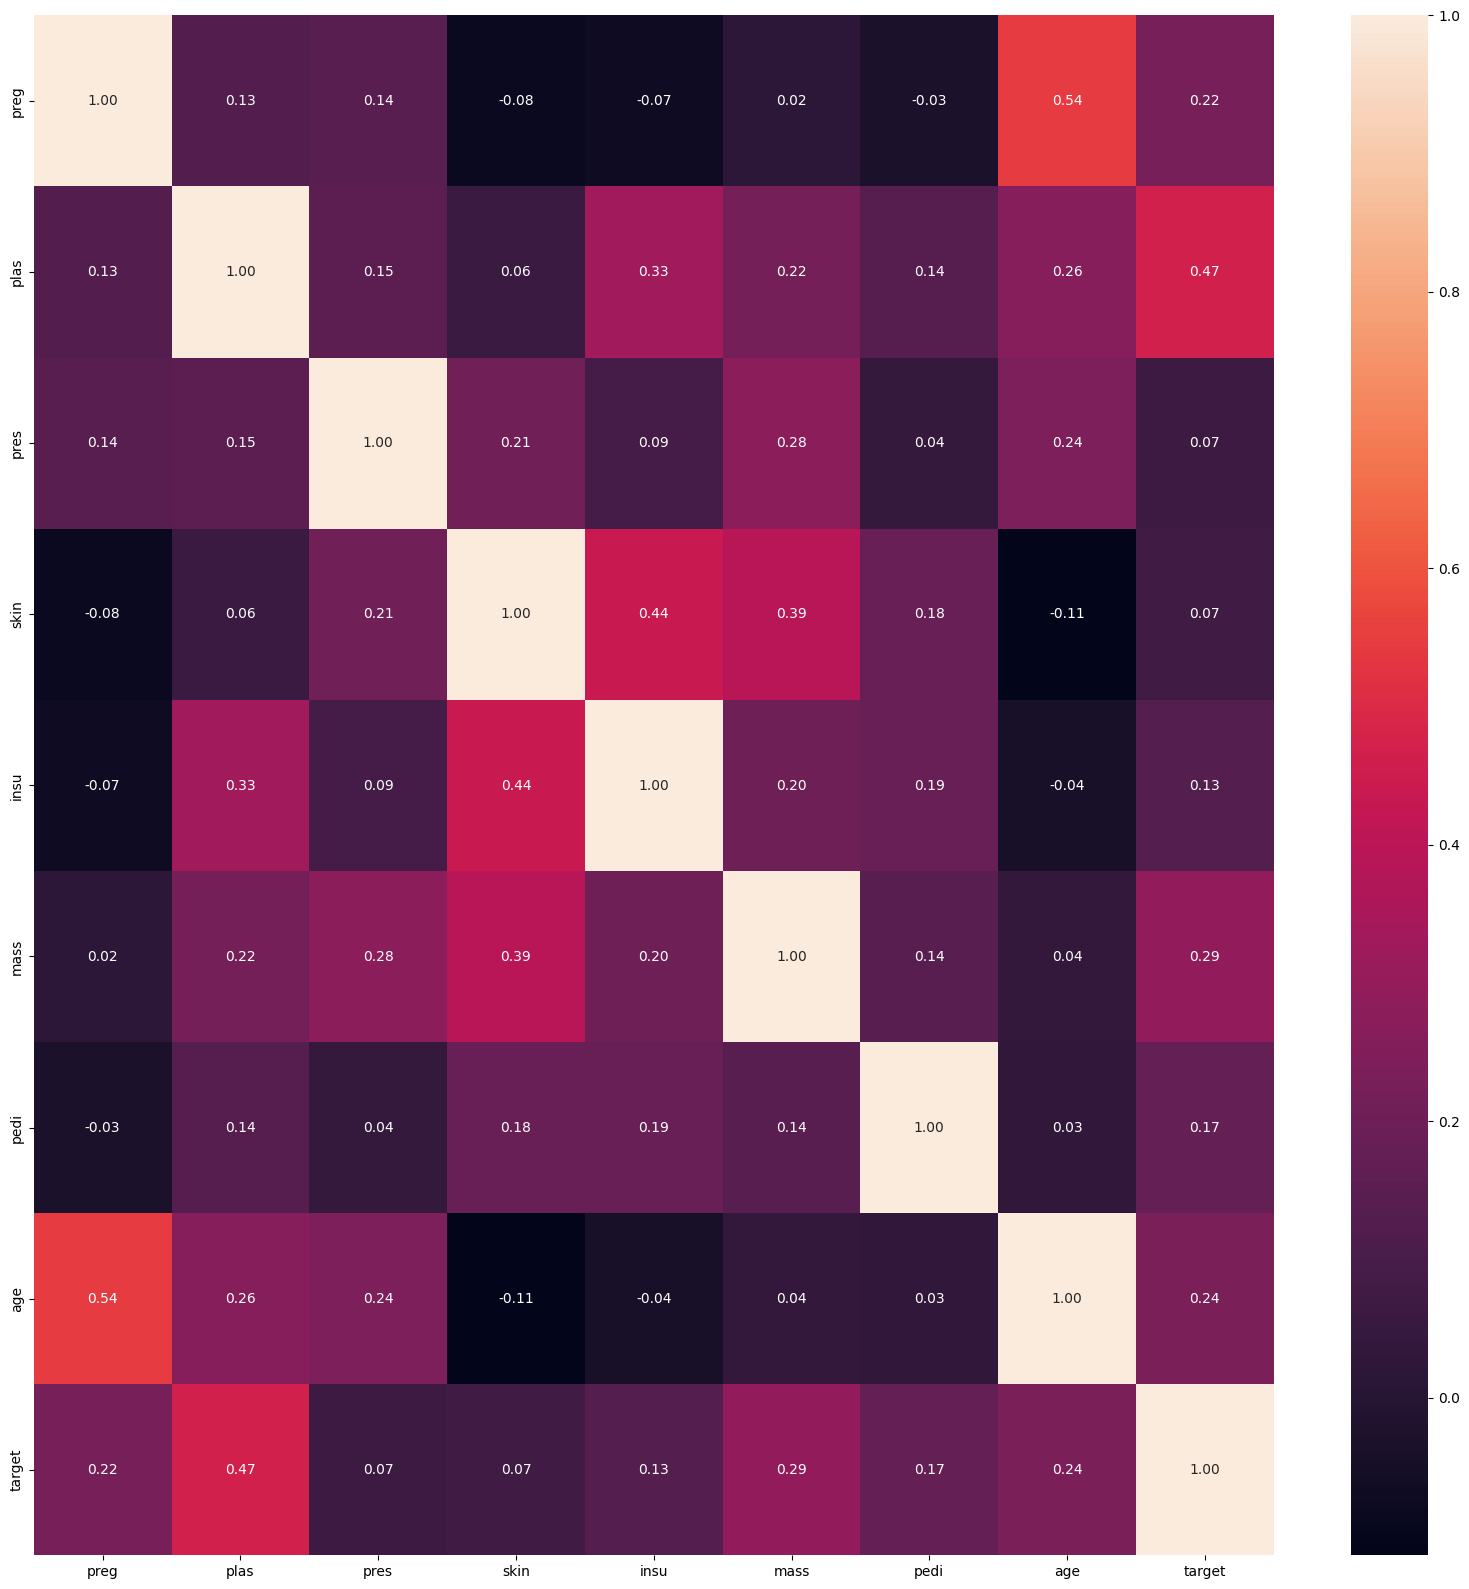

In [20]:
# Visualizar a correlação entre as features

corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f")

plt.show()